In [183]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime,date
## new 
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import tensorflow as tf
import gpflow
from firebase_admin import credentials
from firebase_admin import firestore
import firebase_admin
#import matplotlib.pyplot as plt
import firebase_admin
from firebase_admin import credentials
import json
import os
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

In [184]:

def connect_db(user_id):
    user_id= user_id.lower()
    if not firebase_admin._apps:
        cred = credentials.Certificate('sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json') 
        default_app = firebase_admin.initialize_app(cred)
    
    
    
    
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json"
    cred = r"sim1-ac95f-firebase-adminsdk-3hy48-80b6b88451.json"
    login = credentials.Certificate(cred)
    
    db = firestore.client()
    transaction = db.collection("transaction").stream()

    
    dict_users = {"userid":[],"type":[], "amount":[],"time":[],"date":[]}
    
    for trans in transaction:
        try:
            us = json.loads(str(trans.to_dict()).replace("'",'"').replace(" ","").lower())
            dict_users["userid"].append(us["userid"])
            dict_users["type"].append(us["type"])
            dict_users["amount"].append(us["amount"])
            dict_users["time"].append(us["time"])
            dict_users["date"].append(us["date"])
        except:
            continue
    ##
    df = pd.DataFrame.from_dict(dict_users)
  
    df = df[df["userid"]==user_id]
    
    return df

 

In [185]:
df= connect_db("EJ19NxkmHMMLMJgLcMdP9FfKRSb2")
df["date"] = pd.to_datetime(df['date']+" "+df["time"],errors='coerce')
df["amount"] = df["amount"].astype(float)
df = df.sort_values(by='date')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 28 to 24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   userid  59 non-null     object        
 1   type    59 non-null     object        
 2   amount  59 non-null     float64       
 3   time    59 non-null     object        
 4   date    59 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.8+ KB


In [186]:
df['amount'] = tf.cast(df['amount'], tf.float64)
condition = df["type"] == 'withdrawal'
#df.loc[condition, ['amount']] *= -1

print(df)
for x in ["amount"]:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25

    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)

    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
df = df.dropna(axis = 0)
df


                           userid        type     amount   time  \
28   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal       1.00  20:54   
85   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal       1.00  20:54   
106  ej19nxkmhmmlmjglcmdp9ffkrsb2     deposit       1.00  20:55   
211  ej19nxkmhmmlmjglcmdp9ffkrsb2     deposit       1.00  20:55   
9    ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal      16.00  20:59   
94   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal      16.00  20:59   
12   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal      64.62  22:40   
196  ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal       9.00  18:45   
26   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal     150.00  13:23   
18   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal     143.00  21:29   
72   ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal      37.00  22:19   
112  ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal     100.00  14:53   
204  ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal     160.00  16:08   
105  ej19nxkmhmmlmjglcmdp9ffkrsb2  withdrawal     249.00  19:3

,userid,type,amount,time,date
28,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,1.00,20:54,2022-09-03 20:54:00
85,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,1.00,20:54,2022-09-03 20:54:00
106,ej19nxkmhmmlmjglcmdp9ffkrsb2,deposit,1.00,20:55,2022-09-03 20:55:00
211,ej19nxkmhmmlmjglcmdp9ffkrsb2,deposit,1.00,20:55,2022-09-03 20:55:00
9,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,16.00,20:59,2022-09-03 20:59:00
94,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,16.00,20:59,2022-09-03 20:59:00
12,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,64.62,22:40,2022-10-14 22:40:00
196,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,9.00,18:45,2022-10-15 18:45:00
26,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,150.00,13:23,2022-10-16 13:23:00
18,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,143.00,21:29,2022-10-16 21:29:00


In [187]:
#suggsted appraoch converting to unix timestamp
df["unix_date"] = [datetime.timestamp(dt)/3600 for dt in df["date"]]
df["unix_date"] =tf.cast(df["unix_date"] , tf.float64)
#Batoul
#df = df[20:]
#nuha
df = df[10:]

X = df[["unix_date"]]
X = tf.cast(X, tf.float64)

In [188]:
df['amount'] = tf.cast(df['amount'], tf.float64)
condition = df["type"] == 'withdrawal'
df.loc[condition, ['amount']] *= -1
Y = df[['amount']]
Y = tf.cast(Y, tf.float64)

<ipython-input-188-377cc28b3a2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['amount'] = tf.cast(df['amount'], tf.float64)
/Users/hailah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [189]:
#Create a mapping date for example if the date was 24/04/2022 the day26 that should be mapped to 26/04/2020
#27/04/2020 the day26 that should be mapped is 26/05/2020
#this will help us in creating the X_test see the cell bellow were I created X_test
def get_day_26_mapping(date):
    import datetime
    new_date = []
    for m,d,y in zip(date.dt.month,date.dt.day,date.dt.year):
        #print(m,d,y)
        new_d = 0
        new_m = 0
        new_y = 0
        if d<=26:
            new_d = 26
            new_m = m
            new_y = y
        else:
            new_d = 26
            if m+1>12:
                new_d = 26
                new_m = 1
                new_y = y + 1
            else:
                new_d = 26
                new_m = m + 1
                new_y = y
        new_date.append(datetime.datetime(new_y,new_m,new_d))
    return new_date

df['day_26_mapping_date'] = get_day_26_mapping(df['date'])
df

<ipython-input-189-6fd195ddd1df>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_26_mapping_date'] = get_day_26_mapping(df['date'])


,userid,type,amount,time,date,unix_date,day_26_mapping_date
72,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-37.00,22:19,2022-10-16 22:19:00,462763.316667,2022-10-26
112,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-100.00,14:53,2022-10-17 14:53:00,462779.883333,2022-10-26
204,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-160.00,16:08,2022-10-17 16:08:00,462781.133333,2022-10-26
105,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-249.00,19:36,2022-10-17 19:36:00,462784.600000,2022-10-26
133,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-41.00,19:52,2022-10-17 19:52:00,462784.866667,2022-10-26
127,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-200.00,21:58,2022-10-18 21:58:00,462810.966667,2022-10-26
197,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-38.00,15:04,2022-10-19 15:04:00,462828.066667,2022-10-26
2,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-100.00,19:06,2022-10-19 19:06:00,462832.100000,2022-10-26
66,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-46.00,20:37,2022-10-19 20:37:00,462833.616667,2022-10-26
64,ej19nxkmhmmlmjglcmdp9ffkrsb2,withdrawal,-46.00,20:57,2022-10-19 20:57:00,462833.950000,2022-10-26


40


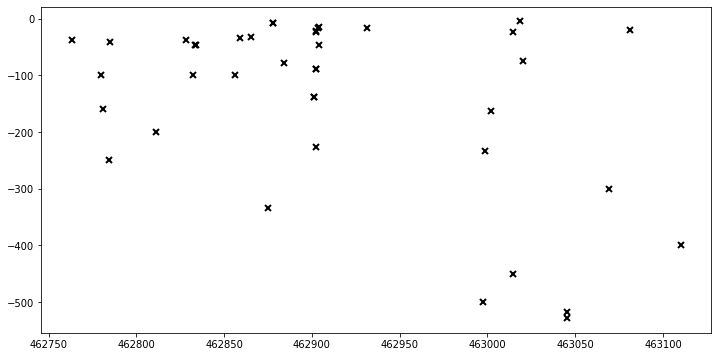

In [191]:
X_train = np.reshape(X,(-1, 1))
Y_train = np.reshape(Y,(-1, 1))
print(len(Y_train))

_ = plt.plot(X_train, Y_train, "kx", mew=2)

In [192]:
k = gpflow.kernels.RBF()
m = gpflow.models.GPR(data=(X_train, Y_train), kernel=k, mean_function=None)

In [193]:
#creating testing data
last_trans = X.numpy().max()

# mapping the last date of transaction to day_26_mapping_date column to get day 26
day_26 = df[last_trans== df["unix_date"]]['day_26_mapping_date']

print("Our last transction", pd.to_datetime(df[last_trans == df["unix_date"]]['date'].values[0]))
print("The nearest day 26 is:", pd.to_datetime(day_26.values[0]))

# converting day_26 to the summation appraoch
day_26_sum = day_26.dt.year+day_26.dt.month+day_26.dt.day+ 23 + 59 +59

# converting day_26 to the to unix timestamp
day_26_unix_time = datetime.timestamp(pd.to_datetime(day_26.values[0]))/3600

print("day_26 if we use the SUM appraoch: ",day_26_sum.values[0])
print("day_26 if we use the unix_time appraoch: ",day_26_unix_time)

#generates points from the first transaction till  the nearst day 26 of the last transaction
X_test = np.linspace(X.numpy().min(), day_26_unix_time , 100).reshape(100, 1) #doxum

Our last transction 2022-10-31 09:03:00
The nearest day 26 is: 2022-11-26 00:00:00
day_26 if we use the SUM appraoch:  2200
day_26 if we use the unix_time appraoch:  463725.0


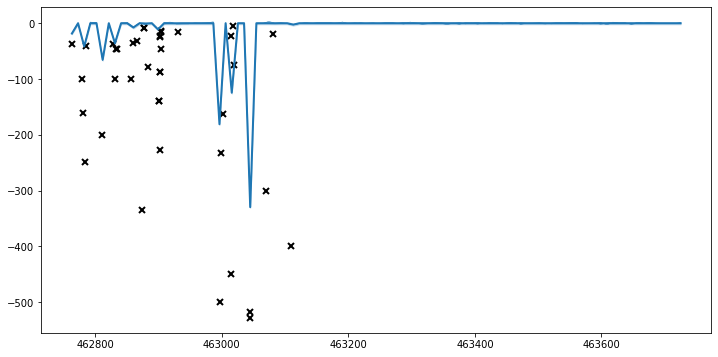

In [194]:
#generate test points for prediction
#predict mean and variance of latent GP at test points
mean, var = m.predict_f(X_test)

#generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = m.predict_f_samples(X_test, 2)  # shape (10, 100, 1)
#plot
plt.figure(figsize=(12, 6))
plt.plot(X_train, Y_train, "kx", mew=2)
plt.plot(X_test, mean, "C0", lw=2)
plt.fill_between(
    X_test[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
_=plt.plot(X_test, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)

In [195]:
def get_day_26_mapping_model(date):
    import datetime
    new_date = []
    for m,d,y in zip(date.dt.month,date.dt.day,date.dt.year):
        #print(m,d,y)
        new_d = 0
        new_m = 0
        new_y = 0
        if d<=26:
            new_d = 26
            new_m = m
            new_y = y
        else:
            new_d = 26
            if m+1>12:
                new_d = 26
                new_m = 1
                new_y = y + 1
            else:
                new_d = 26
                new_m = m + 1
                new_y = y
        #print(d,m,y)
        #print(new_d,new_m,)
        new_date.append(datetime.datetime(new_y,new_m,new_d))
    return new_date
    

In [196]:
def gp_model(user_id):
    
    df = connect_db(user_id)

    df["date"] = pd.to_datetime(df['date']+" "+df["time"],dayfirst = True,errors='coerce')
    df["amount"] = df["amount"].astype(float)
    df['day_26_mapping_date'] = get_day_26_mapping_model(df['date'])
    

    df['amount'] = tf.cast(df['amount'], tf.float64)
    condition = df["type"] == 'withdrawal'
    #df.loc[condition, ['amount']] *= -1
    
    for x in ['amount']:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
     
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
     
        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
    
    df = df.dropna(axis = 0)
    df = df.sort_values(by='date',ascending=True)

    df["unix_date"] = [datetime.timestamp(dt)/3600 for dt in df["date"]]
    df["unix_date"] =tf.cast(df["unix_date"] , tf.float64)
    X = df[["unix_date"]]
    X = tf.cast(X, tf.float64) 
    
    Y = df[['amount']]
    Y = tf.cast(Y, tf.float64) 
    
    
    X_train = np.reshape(X,(-1, 1))
    Y_train = np.reshape(Y,(-1, 1))
    
    k = gpflow.kernels.RBF()
    m = gpflow.models.GPR(data=(X_train, Y_train), kernel=k, mean_function=None)
 
    
    #creating testing data
    last_trans = X.numpy().max()
    # mapping the last date of transaction to day_26_mapping_date column to get day 26
    day_26 = df[last_trans== df["unix_date"]]['day_26_mapping_date']
 
    # converting day_26 to the to unix timestamp
    day_26_unix_time = datetime.timestamp(pd.to_datetime(day_26.values[0]))/3600


    #generates points from the first transaction till  the nearst day 26 of the last transaction
    X_test = np.linspace(X.numpy().min(), day_26_unix_time , 100).reshape(100, 1) #doxum

    mean, var = m.predict_f(X_test)
    #generate 10 samples from posterior
    tf.random.set_seed(1)  # for reproducibility

    samples = m.predict_f_samples(X_test, 10)  # shape (10, 100, 1)
    #plot
    plt.figure(figsize=(12, 6))
    plt.plot(X_train, Y_train, "kx", mew=2)
    plt.plot(X_test, mean, "C0", lw=2)
    plt.fill_between(
        X_test[:, 0],
        mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
        mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
        color="C0",
        alpha=0.2,
    )
    _=plt.plot(X_test, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)